In [0]:
!pip install --upgrade google-cloud-bigquery

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
import os

PROJECT = 'fast-ai-exploration'
os.environ['PROJECT'] = PROJECT

In [0]:
%%bigquery --project $PROJECT data_preview
SELECT
  url, title, score
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  LENGTH(title) > 10
  AND score > 10
  AND LENGTH(url) > 0
LIMIT 10

In [5]:
data_preview.head()

,url,title,score
0,https://www.kickstarter.com/projects/carlosxcl...,"Show HN: Code Cards, Like Texas hold 'em for p...",11
1,http://vancouver.en.craigslist.ca/van/roo/2035...,Best Roommate Ad Ever,11
2,https://github.com/Groundworkstech/Submicron,Deep-Submicron Backdoors,11
3,http://empowerunited.com/,Could this be the solution for the 99%?,11
4,http://themanufacturingrevolution.com/braun-vs...,Braun vs. Apple: Is copying designs theft or i...,11


In [0]:
%%bigquery --project $PROJECT source_num_articles
SELECT
  ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
  COUNT(title) AS num_articles
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
  AND LENGTH(title) > 10
GROUP BY
  source
ORDER BY num_articles DESC

In [11]:
source_num_articles.head()

,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787


In [0]:
%%bigquery --project $PROJECT full_data
SELECT source, LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title FROM
  (SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    title
  FROM
    `bigquery-public-data.hacker_news.stories`
  WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
  )
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch' or source = 'blogspot')

In [13]:
full_data.head()

,source,title
0,github,feminist-software-foundation complains about r...
1,github,expose sps as web services on the fly.
2,github,show hn scrwl shorthand code reading and wr...
3,github,geoip module on nodejs now is a c addon
4,github,show hn linuxexplorer


In [18]:
full_data.shape

(137589, 2)

In [14]:
full_data.source.value_counts()

blogspot      41386
github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

In [16]:
full_data.isna().sum()

source    0
title     0
dtype: int64

In [17]:
full_data['title'].apply(len).describe()

count    137589.000000
mean         47.261489
std          17.091430
min          11.000000
25%          34.000000
50%          47.000000
75%          60.000000
max         138.000000
Name: title, dtype: float64

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

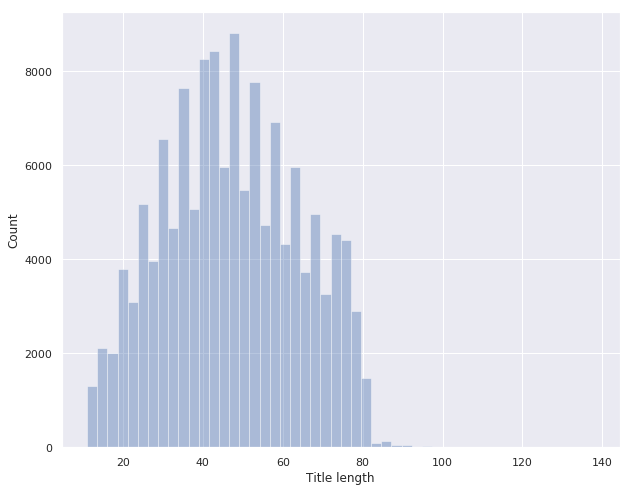

In [41]:
text_lens = full_data['title'].apply(len).values
plt.figure(figsize=(10,8))
sns.set()
g = sns.distplot(text_lens, kde=False, hist_kws={'rwidth':1})
g.set_xlabel('Title length')
g.set_ylabel('Count')
plt.show()

In [42]:
(text_lens <= 11).sum()

400

In [46]:
(text_lens == 138).sum()

1

In [48]:
full_data[text_lens <= 11]['title'].head()

155    react jrate
387    2048 in sed
484    openlaunchd
616    zedshaw tir
686    cloudwazzup
Name: title, dtype: object

In [52]:
full_data[text_lens == 138][['title', 'source']]

,title,source
73504,i ve set up this blog for you to announce upd...,blogspot


In [0]:
full_data = full_data[text_lens < 138].reset_index(drop=True)

In [58]:
full_data.shape

(137588, 2)

In [59]:
# 80% for train
train = full_data.sample(frac=0.8)
full_data.drop(train.index, axis=0, inplace=True)

# 10% for validation
valid = full_data.sample(frac=0.5)
full_data.drop(valid.index, axis=0, inplace=True)

# 10% for test
test = full_data

train.shape, valid.shape, test.shape

((110070, 2), (13759, 2), (13759, 2))

In [63]:
train.source.value_counts()

blogspot      33109
github        29287
techcrunch    24644
nytimes       23030
Name: source, dtype: int64

In [64]:
valid.source.value_counts()

blogspot      4162
github        3627
techcrunch    3136
nytimes       2834
Name: source, dtype: int64

In [65]:
test.source.value_counts()

blogspot      4114
github        3611
techcrunch    3111
nytimes       2923
Name: source, dtype: int64

In [0]:
!mkdir data

In [0]:
train.to_csv('data/train.csv')
valid.to_csv('data/valid.csv')
test.to_csv('data/test.csv')